##### import

In [2]:
from cvzone.ColorModule import ColorFinder
import cvzone
import cv2
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter as KalmanFilterLib
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilterLib
from skimage import exposure
from skimage.exposure import match_histograms
import pickle as pickle

##### Kalmann Filter

In [3]:
class KalmanFilter(object):
    def __init__(self, dt, u_x,u_y, u_z, std_acc, x_std_meas, y_std_meas, z_std_meas):
        """
        :param dt: sampling time (time for 1 cycle)
        :param u_x: acceleration in x-direction
        :param u_y: acceleration in y-direction
        :param std_acc: process noise magnitude
        :param x_std_meas: standard deviation of the measurement in x-direction
        :param y_std_meas: standard deviation of the measurement in y-direction
        """

        # Define sampling time
        self.dt = dt

        # Define the  control input variables
        self.u = np.matrix([u_x,u_y,u_z])

        # Intial State [x, dx, y, dy, z, dz]
        self.x = np.matrix([[0], 
                            [0], 
                            [0], 
                            [0], 
                            [0], 
                            [0]])

        # Define the State Transition Matrix A
        self.F = np.matrix([[1, self.dt, 0, 0, 0, 0],
                            [0, 1, 0, 0, 0, 0],
                            [0, 0, 1, self.dt, 0, 0],
                            [0, 0, 0, 1, 0, 0],
                            [0, 0, 0, 0, 1, self.dt],
                            [0, 0, 0, 0, 0, 1]])

        # Define the Control Input Matrix B
        self.G = np.matrix([[(self.dt**2)/2],
                            [self.dt],
                            [(self.dt**2)/2],
                            [self.dt],
                            [(self.dt**2)/2],
                            [self.dt]])

        # Define Measurement Mapping Matrix
        self.H = np.matrix([[1, 0, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1, 0]])

        #Initial Process Noise Covariance
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2, 0, 0, 0, 0],
                            [(self.dt**3)/2, self.dt**2, 0, 0, 0, 0],
                            [0, 0, (self.dt**4)/4, (self.dt**3)/2, 0, 0],
                            [0, 0, (self.dt**3)/2, self.dt**2, 0, 0],
                            [0, 0, 0, 0, (self.dt**4)/4, (self.dt**3)/2],
                            [0, 0, 0, 0, (self.dt**3)/2, self.dt**2],]) * std_acc**2

        #Initial Measurement Noise Covariance
        self.R = np.matrix([[x_std_meas**2, 0, 0],
                           [0, y_std_meas**2, 0],
                           [0, 0, z_std_meas**2]])

        #Initial Covariance Matrix
        self.P = np.eye(self.F.shape[1])

    def predict(self):
        # Refer to :Eq.(9) and Eq.(10)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795

        # Update time state
        #x_k =Ax_(k-1) + Bu_(k-1)     Eq.(9)
        # print(np.shape(np.dot(self.F, self.x)), np.dot(self.F, self.x))
        # print(np.shape(np.dot(self.G, self.u)), np.dot(self.G, self.u))
        # self.x = np.dot(self.F, self.x) + np.dot(self.G, self.u)
        # print(np.shape(self.x), self.x)
        self.x = np.dot(self.F, self.x) # disable control input

        # Calculate error covariance
        # P= A*P*A' + Q               Eq.(10)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return (self.x[0], self.x[2], self.x[4])

    def update(self, z):

        # Refer to :Eq.(11), Eq.(12) and Eq.(13)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  #Eq.(11)

        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))   #Eq.(12)

        I = np.eye(self.H.shape[1])
        # temp = I - (K * self.H)
        temp = I - (K * self.H)

        # Update error covariance matrix
        self.P = temp * self.P * np.linalg.inv(temp) + K*self.R*K.T  #Eq.(13)
        return (self.x[0], self.x[2], self.x[4])


In [4]:
class KalmanFilter1D(object):
    def __init__(self, dt, u, std_acc, std_meas):
        self.dt = dt
        self.u = u
        self.std_acc = std_acc

        self.F = np.matrix([[1, self.dt],
                            [0, 1]])
        self.G = np.matrix([[(self.dt**2)/2], 
                            [self.dt]])

        self.H = np.matrix([[1, 0]])

        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2

        self.R = std_meas**2

        self.P = np.eye(self.F.shape[1])
        
        self.x = np.matrix([[0], 
                            [0]])

        # print(self.Q)


    def predict(self):
        # Ref :Eq.(9) and Eq.(10)

        # Update time state
        self.x = np.dot(self.F, self.x) + np.dot(self.G, self.u)

        # Calculate error covariance
        # P= A*P*A' + Q
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x[0]

    def update(self, z):
        # Ref :Eq.(11) , Eq.(11) and Eq.(13)
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Eq.(11)

        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  # Eq.(12)

        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P  # Eq.(13)
        # print("self.x : {0}".format(self.x))
        return self.x[0]

##### object detection + tracking

In [5]:
warnaBolaHsvJose = {
        # "hijau muda"        : {'hmin': 59, 'smin': 100, 'vmin': 0, 'hmax': 82, 'smax': 174, 'vmax': 255},    # bola hijau muda
        "kuning kehijauan"  : {'hmin': 22, 'smin': 70, 'vmin': 0, 'hmax': 33, 'smax': 144, 'vmax': 255},    # bola kuning kehijauan
        "hijau tua"         : {'hmin': 42, 'smin': 35, 'vmin': 98, 'hmax': 58, 'smax': 255, 'vmax': 255},    # bola hijau tua
        "biru muda"         : {'hmin': 98, 'smin': 35, 'vmin': 139, 'hmax': 141, 'smax': 84, 'vmax': 255},   # bola biru muda
        # "hijau telur asin"  : {'hmin': 84, 'smin': 61, 'vmin': 137, 'hmax': 105, 'smax': 171, 'vmax': 255},   # bila hijau telur asin
        "biru telur unta"   : {'hmin': 80, 'smin': 80, 'vmin': 98, 'hmax': 95, 'smax': 140, 'vmax': 255},    # bola biru telur unta
        "oranye"            : {'hmin': 14, 'smin': 119, 'vmin': 172, 'hmax': 23, 'smax': 241, 'vmax': 255},     # bola oranye
        # "pink"              : {'hmin': 156, 'smin': 20, 'vmin': 164, 'hmax': 172, 'smax': 70, 'vmax': 255},   # bola pink
        # "pink"              : {'hmin': 150, 'smin': 44, 'vmin': 130, 'hmax': 179, 'smax': 70, 'vmax': 255},   # bola pink alternatif
        "ungu"              : {'hmin': 140, 'smin': 41, 'vmin': 107, 'hmax': 162, 'smax': 148, 'vmax': 255},   # ungu
        # "krem"              : {'hmin': 0, 'smin': 0, 'vmin': 155, 'hmax': 179, 'smax': 26, 'vmax': 255},      # bola krem -> tapi karena cahaya malah mirip putih
    }
warnaBolaHsvMoses = {
        # "hijau muda"        : {'hmin': 59, 'smin': 100, 'vmin': 0, 'hmax': 82, 'smax': 174, 'vmax': 255},    # bola hijau muda
        "kuning kehijauan"  : {'hmin': 22, 'smin': 70, 'vmin': 0, 'hmax': 40, 'smax': 144, 'vmax': 255},    # bola kuning kehijauan
        "hijau tua"         : {'hmin': 34, 'smin': 26, 'vmin': 75, 'hmax': 58, 'smax': 199, 'vmax': 255},    # bola hijau tua
        "biru muda"         : {'hmin': 90, 'smin': 25, 'vmin': 0, 'hmax': 140, 'smax': 255, 'vmax': 255},   # bola biru muda
        # "hijau telur asin"  : {'hmin': 84, 'smin': 61, 'vmin': 137, 'hmax': 105, 'smax': 171, 'vmax': 255},   # bila hijau telur asin
        "biru telur unta"   : {'hmin': 66, 'smin': 40, 'vmin': 90, 'hmax': 92, 'smax': 255, 'vmax': 255},    # bola biru telur unta
        "oranye"            : {'hmin': 14, 'smin': 119, 'vmin': 172, 'hmax': 23, 'smax': 241, 'vmax': 255},     # bola oranye
        # "pink"              : {'hmin': 156, 'smin': 20, 'vmin': 164, 'hmax': 172, 'smax': 70, 'vmax': 255},   # bola pink
        # "pink"              : {'hmin': 150, 'smin': 44, 'vmin': 130, 'hmax': 179, 'smax': 70, 'vmax': 255},   # bola pink alternatif
        "ungu"              : {'hmin': 110, 'smin': 24, 'vmin': 107, 'hmax': 162, 'smax': 148, 'vmax': 255},   # ungu
        # "krem"              : {'hmin': 0, 'smin': 0, 'vmin': 155, 'hmax': 179, 'smax': 26, 'vmax': 255},      # bola krem -> tapi karena cahaya malah mirip putih
    }
warnaBolaHsvWisnu = {
        # "hijau muda"        : {'hmin': 59, 'smin': 100, 'vmin': 0, 'hmax': 82, 'smax': 174, 'vmax': 255},    # bola hijau muda
        "kuning kehijauan"  : {'hmin': 22, 'smin': 70, 'vmin': 0, 'hmax': 33, 'smax': 144, 'vmax': 255},    # bola kuning kehijauan
        "hijau tua"         : {'hmin': 34, 'smin': 26, 'vmin': 75, 'hmax': 58, 'smax': 199, 'vmax': 255},    # bola hijau tua
        "biru muda"         : {'hmin': 98, 'smin': 33, 'vmin': 78, 'hmax': 140, 'smax': 150, 'vmax': 255},   # bola biru muda
        # "hijau telur asin"  : {'hmin': 84, 'smin': 61, 'vmin': 137, 'hmax': 105, 'smax': 171, 'vmax': 255},   # bila hijau telur asin
        "biru telur unta"   : {'hmin': 80, 'smin': 80, 'vmin': 57, 'hmax': 95, 'smax': 227, 'vmax': 255},    # bola biru telur unta
        "oranye"            : {'hmin': 14, 'smin': 119, 'vmin': 172, 'hmax': 23, 'smax': 241, 'vmax': 255},     # bola oranye
        # "pink"              : {'hmin': 156, 'smin': 20, 'vmin': 164, 'hmax': 172, 'smax': 70, 'vmax': 255},   # bola pink
        # "pink"              : {'hmin': 150, 'smin': 44, 'vmin': 130, 'hmax': 179, 'smax': 70, 'vmax': 255},   # bola pink alternatif
        "ungu"              : {'hmin': 140, 'smin': 41, 'vmin': 107, 'hmax': 162, 'smax': 148, 'vmax': 255},   # ungu
        # "krem"              : {'hmin': 0, 'smin': 0, 'vmin': 155, 'hmax': 179, 'smax': 26, 'vmax': 255},      # bola krem -> tapi karena cahaya malah mirip putih
    }

# take 2
# warnaBolaHsv = {
#         # "hijau muda"        : {'hmin': 59, 'smin': 100, 'vmin': 0, 'hmax': 82, 'smax': 174, 'vmax': 255},    # bola hijau muda
#         "kuning kehijauan"  : {'hmin': 22, 'smin': 70, 'vmin': 0, 'hmax': 33, 'smax': 144, 'vmax': 255},    # bola kuning kehijauan
#         "hijau tua"         : {'hmin': 42, 'smin': 80, 'vmin': 98, 'hmax': 58, 'smax': 255, 'vmax': 255},    # bola hijau tua
#         "biru muda"         : {'hmin': 98, 'smin': 46, 'vmin': 90, 'hmax': 133, 'smax': 137, 'vmax': 255},   # bola biru muda
#         # "hijau telur asin"  : {'hmin': 84, 'smin': 61, 'vmin': 137, 'hmax': 105, 'smax': 171, 'vmax': 255},   # bila hijau telur asin
#         "biru telur unta"   : {'hmin': 80, 'smin': 80, 'vmin': 98, 'hmax': 95, 'smax': 140, 'vmax': 255},    # bola biru telur unta
#         "oranye"            : {'hmin': 14, 'smin': 119, 'vmin': 172, 'hmax': 23, 'smax': 241, 'vmax': 255},     # bola oranye
#         # "pink"              : {'hmin': 156, 'smin': 20, 'vmin': 164, 'hmax': 172, 'smax': 70, 'vmax': 255},   # bola pink
#         # "pink"              : {'hmin': 150, 'smin': 44, 'vmin': 130, 'hmax': 179, 'smax': 70, 'vmax': 255},   # bola pink alternatif
#         "ungu"              : {'hmin': 140, 'smin': 41, 'vmin': 107, 'hmax': 162, 'smax': 148, 'vmax': 255},   # ungu
#         # "krem"              : {'hmin': 0, 'smin': 0, 'vmin': 155, 'hmax': 179, 'smax': 26, 'vmax': 255},      # bola krem -> tapi karena cahaya malah mirip putih
#     }

# take 1
# warnaBolaHsv = {
#         # "hijau muda"        : {'hmin': 59, 'smin': 100, 'vmin': 0, 'hmax': 82, 'smax': 174, 'vmax': 255},    # bola hijau muda
#         "kuning kehijauan"  : {'hmin': 30, 'smin': 41, 'vmin': 0, 'hmax': 38, 'smax': 174, 'vmax': 255},    # bola kuning kehijauan
#         "hijau tua"         : {'hmin': 42, 'smin': 80, 'vmin': 98, 'hmax': 58, 'smax': 255, 'vmax': 255},    # bola hijau tua
#         "biru muda"         : {'hmin': 98, 'smin': 46, 'vmin': 90, 'hmax': 133, 'smax': 137, 'vmax': 255},   # bola biru muda
#         # "hijau telur asin"  : {'hmin': 84, 'smin': 61, 'vmin': 137, 'hmax': 105, 'smax': 171, 'vmax': 255},   # bila hijau telur asin
#         "biru telur unta"   : {'hmin': 80, 'smin': 80, 'vmin': 98, 'hmax': 95, 'smax': 140, 'vmax': 255},    # bola biru telur unta
#         "oranye"            : {'hmin': 14, 'smin': 119, 'vmin': 172, 'hmax': 23, 'smax': 241, 'vmax': 255},     # bola oranye
#         # "pink"              : {'hmin': 156, 'smin': 20, 'vmin': 164, 'hmax': 172, 'smax': 70, 'vmax': 255},   # bola pink
#         # "pink"              : {'hmin': 150, 'smin': 44, 'vmin': 130, 'hmax': 179, 'smax': 70, 'vmax': 255},   # bola pink alternatif
#         "ungu"              : {'hmin': 140, 'smin': 41, 'vmin': 107, 'hmax': 162, 'smax': 148, 'vmax': 255},   # ungu
#         # "krem"              : {'hmin': 0, 'smin': 0, 'vmin': 155, 'hmax': 179, 'smax': 26, 'vmax': 255},      # bola krem -> tapi karena cahaya malah mirip putih
#     }


# tes di wisnu
# warnaBolaHsv = {
#     # "hijau muda"        : {'hmin': 49, 'smin': 93, 'vmin': 126, 'hmax': 80, 'smax': 253, 'vmax': 255},    # bola hijau muda
#     # "kuning kehijauan"  : {'hmin': 23, 'smin': 41, 'vmin': 126, 'hmax': 62, 'smax': 174, 'vmax': 227},    # bola kuning kehijauan
#     "hijau tua"         : {'hmin': 35, 'smin': 42, 'vmin': 123, 'hmax': 73, 'smax': 190, 'vmax': 255},    # bola hijau tua
#     # "biru muda"         : {'hmin': 94, 'smin': 47, 'vmin': 118, 'hmax': 109, 'smax': 204, 'vmax': 255},   # bola biru muda
#     # "hijau telur asin"  : {'hmin': 84, 'smin': 61, 'vmin': 137, 'hmax': 105, 'smax': 171, 'vmax': 255},   # bila hijau telur asin
#     # "biru telur unta"   : {'hmin': 83, 'smin': 69, 'vmin': 90, 'hmax': 108, 'smax': 255, 'vmax': 255},    # bola biru telur unta
#     "oranye"            : {'hmin': 12, 'smin': 129, 'vmin': 217, 'hmax': 39, 'smax': 255, 'vmax': 255},     # bola oranye
#     # "pink"              : {'hmin': 149, 'smin': 20, 'vmin': 164, 'hmax': 179, 'smax': 79, 'vmax': 255},   # bola pink
#     "ungu"              : {'hmin': 142, 'smin': 101, 'vmin': 138, 'hmax': 171, 'smax': 243, 'vmax': 255},   # ungu
#     # "krem"              : {'hmin': 0, 'smin': 0, 'vmin': 155, 'hmax': 179, 'smax': 26, 'vmax': 255},      # bola krem -> tapi karena cahaya malah mirip putih
# }


## kalman filter

In [6]:
def objectTrackingKalmanFilter(videoPath, warnaBolaHsv, isLive, isShow):
    if(not(isLive)):
        # Create opencv video capture object
        # cap = cv2.VideoCapture('video/tes_jarak_bola.mp4')
        cap = cv2.VideoCapture(videoPath)
    else:
        cap = cv2.VideoCapture(0)

    # cap.set(3, 1280)
    # cap.set(4, 720)
    
    myColorFinder = ColorFinder(0)
    
    kalmanFilterBola = {}
    kalmanFilterSupportingAttributes = {}
    kalmanFilterHasil = {}
    for warnaBola in warnaBolaHsv:
        kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
        kalmanFilterSupportingAttributes[warnaBola] = {"is_active" : False, "is_new" : True, "frame_since_last_detected" : 0}
        # kalmanFilterHasil[warnaBola] = []
    MAXFRAMESINCEDETECTED = 10

    #define kernel size  
    kernel = np.ones((7,7),np.uint8)

    # init object
    x, y, z = 0, 0, 0
    frameNum = 0

    try:
        while(True):
            success, img = cap.read()
            img = cv2.resize(img, (2560, 1440))
            imgOutput = img.copy()
            allMask = []
            frameNum += 1
            kalmanFilterHasil[frameNum] = {}
            kalmanFilterHasilLocal = kalmanFilterHasil[frameNum]
            # h, w, _ = img.shape
            for warnaBola in warnaBolaHsv:
                hsvVals = warnaBolaHsv[warnaBola]
                KF_1D = kalmanFilterBola[warnaBola]
                kalmanFilterSupportingAttributesLocal = kalmanFilterSupportingAttributes[warnaBola]
                # kalmanFilterHasilLokal = kalmanFilterHasil[warnaBola]
                imageColor, mask = myColorFinder.update(img, hsvVals)
                # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

                # Remove unnecessary noise from mask
                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if(len(contours) > 0):
                    if(not(kalmanFilterSupportingAttributesLocal["is_active"])):
                        kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
                        KF_1D = kalmanFilterBola[warnaBola]
                        kalmanFilterSupportingAttributesLocal["is_active"] = True

                    kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] = 0

                    biggestContour = max(contours, key = cv2.contourArea)
                    cv2.drawContours(imgOutput, biggestContour, -1, (0,255,0), 3)

                    # bisa dipake buat approximate lokasi di video depth
                    # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
                    # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
                    x,y,w,h = cv2.boundingRect(biggestContour) 
                    cv2.rectangle(imgOutput,(x,y),(x+w,y+h),(255,0,0),2)

                    # Predict
                    # (x, y, z) = KF.predict()
                    x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()

                    # Update
                    M = cv2.moments(biggestContour)
                    if(M['m00'] != 0):
                        cx = int(M['m10']/M['m00'])
                        cy = int(M['m01']/M['m00'])
                    else:
                        cx = x
                        cy = y
                    # (x1, y1, z1) = KF.update([cx, cy, 0])
                    x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

                    # Draw a rectangle as the predicted object position
                    # cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
                    cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
                else:
                    if(kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] > MAXFRAMESINCEDETECTED):
                        kalmanFilterSupportingAttributesLocal["is_active"] = False
                    else:
                        kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] += 1
                        # Predict
                        # (x, y, z) = KF.predict()
                        x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()

                        cx = x
                        cy = y
                        x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

                        # Draw a rectangle as the predicted object position
                        # cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
                        cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
                if(kalmanFilterSupportingAttributesLocal["is_active"]):
                    cv2.putText(imgOutput, warnaBola, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(imgOutput, str(cv2.contourArea(biggestContour)), (int(x), int(y)-25), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    kalmanFilterHasilLocal[warnaBola] = [x[0,0], y[0,0]]
                    # fileResult1.write("{:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("nilai: {:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("shape: {}, {}, ".format(np.shape(x[0,0]), np.shape(y[0,0])))
                else:
                    # fileResult1.write("-, -, ")
                    kalmanFilterHasilLocal[warnaBola] = [-1, -1]
                allMask.append(mask)
            # fileResult1.write("\n")
            
            if(isShow):
                # imageStack = cvzone.stackImages([img, mask], 2, 0.5)
                imgOutput = cv2.resize(imgOutput, (1280, 720))
                cv2.imshow("imageOri", imgOutput)

                imageStack = cvzone.stackImages(allMask, 2, 0.5)
                imageStack = cv2.resize(imageStack, (1280, 720))
                cv2.imshow("imageStack", imageStack)


            if cv2.waitKey(2) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    break

            cv2.waitKey(1)
    except Exception as e:
        print("error: ", e)
        cap.release()
        cv2.destroyAllWindows()
    return kalmanFilterHasil
    # fileResult1.close()


In [7]:
# ide 1, coba pake offset di salah satu pixelnya

# def objectTrackingKalmanFilter(videoPath, warnaBolaHsvOri, warnaBolaOffset, isLive, isShow):
#     if(not(isLive)):
#         # Create opencv video capture object
#         # cap = cv2.VideoCapture('video/tes_jarak_bola.mp4')
#         cap = cv2.VideoCapture(videoPath)
#     else:
#         cap = cv2.VideoCapture(0)

#     # cap.set(3, 1280)
#     # cap.set(4, 720)
    
#     myColorFinder = ColorFinder(0)
    
#     kalmanFilterBola = {}
#     kalmanFilterSupportingAttributes = {}
#     kalmanFilterHasil = {}
#     warnaBolaHsv = {}
#     for warnaBola in warnaBolaHsvOri:
#         warnaBolaHsv[warnaBola] = {}
#         warnaBolaHsv[warnaBola]["hmin"] = warnaBolaHsvOri[warnaBola]["hmin"] + warnaBolaOffset[0]
#         warnaBolaHsv[warnaBola]["hmax"] = warnaBolaHsvOri[warnaBola]["hmax"] + warnaBolaOffset[0]
#         warnaBolaHsv[warnaBola]["smin"] = warnaBolaHsvOri[warnaBola]["smin"] + warnaBolaOffset[1]
#         warnaBolaHsv[warnaBola]["smax"] = warnaBolaHsvOri[warnaBola]["smax"] + warnaBolaOffset[1]
#         warnaBolaHsv[warnaBola]["vmin"] = warnaBolaHsvOri[warnaBola]["vmin"] + warnaBolaOffset[2]
#         warnaBolaHsv[warnaBola]["vmax"] = warnaBolaHsvOri[warnaBola]["vmax"] + warnaBolaOffset[2]
#         kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
#         kalmanFilterSupportingAttributes[warnaBola] = {"is_active" : False, "is_new" : True, "frame_since_last_detected" : 0}
#         # kalmanFilterHasil[warnaBola] = []
#     MAXFRAMESINCEDETECTED = 10

#     #define kernel size  
#     kernel = np.ones((7,7),np.uint8)

#     # init object
#     x, y, z = 0, 0, 0
#     frameNum = 0

#     try:
#         while(True):
#             success, img = cap.read()
#             img = cv2.resize(img, (2560, 1440))
#             imgOutput = img.copy()
#             allMask = []
#             frameNum += 1
#             kalmanFilterHasil[frameNum] = {}
#             kalmanFilterHasilLocal = kalmanFilterHasil[frameNum]
#             # h, w, _ = img.shape
#             for warnaBola in warnaBolaHsv:
#                 hsvVals = warnaBolaHsv[warnaBola]
#                 KF_1D = kalmanFilterBola[warnaBola]
#                 kalmanFilterSupportingAttributesLocal = kalmanFilterSupportingAttributes[warnaBola]
#                 # kalmanFilterHasilLokal = kalmanFilterHasil[warnaBola]
#                 imageColor, mask = myColorFinder.update(img, hsvVals)
#                 # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

#                 # Remove unnecessary noise from mask
#                 mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
#                 mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

#                 contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#                 if(len(contours) > 0):
#                     if(not(kalmanFilterSupportingAttributesLocal["is_active"])):
#                         kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
#                         KF_1D = kalmanFilterBola[warnaBola]
#                         kalmanFilterSupportingAttributesLocal["is_active"] = True

#                     kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] = 0

#                     biggestContour = max(contours, key = cv2.contourArea)
#                     cv2.drawContours(imgOutput, biggestContour, -1, (0,255,0), 3)

#                     # bisa dipake buat approximate lokasi di video depth
#                     # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
#                     # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
#                     x,y,w,h = cv2.boundingRect(biggestContour) 
#                     cv2.rectangle(imgOutput,(x,y),(x+w,y+h),(255,0,0),2)

#                     # Predict
#                     # (x, y, z) = KF.predict()
#                     x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()

#                     # Update
#                     M = cv2.moments(biggestContour)
#                     if(M['m00'] != 0):
#                         cx = int(M['m10']/M['m00'])
#                         cy = int(M['m01']/M['m00'])
#                     else:
#                         cx = x
#                         cy = y
#                     # (x1, y1, z1) = KF.update([cx, cy, 0])
#                     x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

#                     # Draw a rectangle as the predicted object position
#                     cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
#                     cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
#                 else:
#                     if(kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] > MAXFRAMESINCEDETECTED):
#                         kalmanFilterSupportingAttributesLocal["is_active"] = False
#                     else:
#                         kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] += 1
#                         # Predict
#                         # (x, y, z) = KF.predict()
#                         x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()

#                         cx = x
#                         cy = y
#                         x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

#                         # Draw a rectangle as the predicted object position
#                         cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
#                         cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
#                 if(kalmanFilterSupportingAttributesLocal["is_active"]):
#                     cv2.putText(imgOutput, warnaBola, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
#                     cv2.putText(imgOutput, str(cv2.contourArea(biggestContour)), (int(x), int(y)-25), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
#                     kalmanFilterHasilLocal[warnaBola] = [x[0,0], y[0,0]]
#                     # fileResult1.write("{:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
#                     # print("nilai: {:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
#                     # print("shape: {}, {}, ".format(np.shape(x[0,0]), np.shape(y[0,0])))
#                 else:
#                     # fileResult1.write("-, -, ")
#                     kalmanFilterHasilLocal[warnaBola] = [-1, -1]
#                 allMask.append(mask)
#             # fileResult1.write("\n")
            
#             if(isShow):
#                 # imageStack = cvzone.stackImages([img, mask], 2, 0.5)
#                 imgOutput = cv2.resize(imgOutput, (1280, 720))
#                 cv2.imshow("imageOri", imgOutput)

#                 imageStack = cvzone.stackImages(allMask, 2, 0.5)
#                 imageStack = cv2.resize(imageStack, (1280, 720))
#                 cv2.imshow("imageStack", imageStack)


#             if cv2.waitKey(2) & 0xFF == ord('q'):
#                     cap.release()
#                     cv2.destroyAllWindows()
#                     break

#             cv2.waitKey(1)
#     except Exception as e:
#         print("error: ", e)
#         cap.release()
#         cv2.destroyAllWindows()
#     return kalmanFilterHasil
#     # fileResult1.close()


In [8]:
# ide 2 pake histogram matching

# def objectTrackingKalmanFilter(videoPath, imageForHistogramMatching, isLive, isShow):
#     if(not(isLive)):
#         # Create opencv video capture object
#         # cap = cv2.VideoCapture('video/tes_jarak_bola.mp4')
#         cap = cv2.VideoCapture(videoPath)
#     else:
#         cap = cv2.VideoCapture(0)

#     # cap.set(3, 1280)
#     # cap.set(4, 720)
    
#     myColorFinder = ColorFinder(0)
    
#     kalmanFilterBola = {}
#     kalmanFilterSupportingAttributes = {}
#     kalmanFilterHasil = {}
#     for warnaBola in warnaBolaHsv:
#         kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
#         kalmanFilterSupportingAttributes[warnaBola] = {"is_active" : False, "is_new" : True, "frame_since_last_detected" : 0}
#         # kalmanFilterHasil[warnaBola] = []
#     MAXFRAMESINCEDETECTED = 10

#     #define kernel size  
#     kernel = np.ones((7,7),np.uint8)

#     # init object
#     x, y, z = 0, 0, 0
#     frameNum = 0

#     try:
#         while(True):
#             success, img = cap.read()
#             img = matched = match_histograms(img, imageForHistogramMatching ,
#                            channel_axis=-1)
#             img = cv2.resize(img, (2560, 1440))
#             imgOutput = img.copy()
#             allMask = []
#             frameNum += 1
#             kalmanFilterHasil[frameNum] = {}
#             kalmanFilterHasilLocal = kalmanFilterHasil[frameNum]
#             # h, w, _ = img.shape
#             for warnaBola in warnaBolaHsv:
#                 hsvVals = warnaBolaHsv[warnaBola]
#                 KF_1D = kalmanFilterBola[warnaBola]
#                 kalmanFilterSupportingAttributesLocal = kalmanFilterSupportingAttributes[warnaBola]
#                 # kalmanFilterHasilLokal = kalmanFilterHasil[warnaBola]
#                 imageColor, mask = myColorFinder.update(img, hsvVals)
#                 # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

#                 # Remove unnecessary noise from mask
#                 mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
#                 mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

#                 contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#                 if(len(contours) > 0):
#                     if(not(kalmanFilterSupportingAttributesLocal["is_active"])):
#                         kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
#                         KF_1D = kalmanFilterBola[warnaBola]
#                         kalmanFilterSupportingAttributesLocal["is_active"] = True

#                     kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] = 0

#                     biggestContour = max(contours, key = cv2.contourArea)
#                     cv2.drawContours(imgOutput, biggestContour, -1, (0,255,0), 3)

#                     # bisa dipake buat approximate lokasi di video depth
#                     # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
#                     # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
#                     x,y,w,h = cv2.boundingRect(biggestContour) 
#                     cv2.rectangle(imgOutput,(x,y),(x+w,y+h),(255,0,0),2)

#                     # Predict
#                     # (x, y, z) = KF.predict()
#                     x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()

#                     # Update
#                     M = cv2.moments(biggestContour)
#                     if(M['m00'] != 0):
#                         cx = int(M['m10']/M['m00'])
#                         cy = int(M['m01']/M['m00'])
#                     else:
#                         cx = x
#                         cy = y
#                     # (x1, y1, z1) = KF.update([cx, cy, 0])
#                     x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

#                     # Draw a rectangle as the predicted object position
#                     cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
#                     cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
#                 else:
#                     if(kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] > MAXFRAMESINCEDETECTED):
#                         kalmanFilterSupportingAttributesLocal["is_active"] = False
#                     else:
#                         kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] += 1
#                         # Predict
#                         # (x, y, z) = KF.predict()
#                         x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()

#                         cx = x
#                         cy = y
#                         x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

#                         # Draw a rectangle as the predicted object position
#                         cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
#                         cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
#                 if(kalmanFilterSupportingAttributesLocal["is_active"]):
#                     cv2.putText(imgOutput, warnaBola, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
#                     cv2.putText(imgOutput, str(cv2.contourArea(biggestContour)), (int(x), int(y)-25), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
#                     kalmanFilterHasilLocal[warnaBola] = [x[0,0], y[0,0]]
#                     # fileResult1.write("{:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
#                     # print("nilai: {:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
#                     # print("shape: {}, {}, ".format(np.shape(x[0,0]), np.shape(y[0,0])))
#                 else:
#                     # fileResult1.write("-, -, ")
#                     kalmanFilterHasilLocal[warnaBola] = [-1, -1]
#                 allMask.append(mask)
#             # fileResult1.write("\n")
            
#             if(isShow):
#                 # imageStack = cvzone.stackImages([img, mask], 2, 0.5)
#                 imgOutput = cv2.resize(imgOutput, (1280, 720))
#                 cv2.imshow("imageOri", imgOutput)

#                 imageStack = cvzone.stackImages(allMask, 2, 0.5)
#                 imageStack = cv2.resize(imageStack, (1280, 720))
#                 cv2.imshow("imageStack", imageStack)


#             if cv2.waitKey(2) & 0xFF == ord('q'):
#                     cap.release()
#                     cv2.destroyAllWindows()
#                     break

#             cv2.waitKey(1)
#     except Exception as e:
#         print("error: ", e)
#         cap.release()
#         cv2.destroyAllWindows()
#     return kalmanFilterHasil
#     # fileResult1.close()


## kalman Filter Lib

In [9]:
from filterpy.common import Q_discrete_white_noise

def createKalmanFilterLib1D(dim_x, dim_z, dt, u, std_acc, std_meas):
    kalmanFilter = KalmanFilterLib(dim_x, dim_z)
    kalmanFilter.x = np.array([0., 0.])
    kalmanFilter.F = np.array([[1.,dt],
                               [0.,1.]])
    kalmanFilter.H = np.array([[1.,0.]])
    kalmanFilter.R = 0.01
    kalmanFilter.Q = Q_discrete_white_noise(dim=dim_x, dt=dt, var=std_acc)
    return kalmanFilter
    

def objectTrackingKalmanFilterLib(videoPath, isLive, isShow):
    if(not(isLive)):
        # Create opencv video capture object
        # cap = cv2.VideoCapture('video/tes_jarak_bola.mp4')
        cap = cv2.VideoCapture(videoPath)
    else:
        cap = cv2.VideoCapture(0)

    # cap.set(3, 1280)
    # cap.set(4, 720)
    
    myColorFinder = ColorFinder(0)
    
    kalmanFilterBola = {}
    kalmanFilterSupportingAttributes = {}
    kalmanFilterHasil = {}
    for warnaBola in warnaBolaHsv:
        kalmanFilterBola[warnaBola] = {"KF_X" : createKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1), "KF_Y" : createKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1)}
        kalmanFilterSupportingAttributes[warnaBola] = {"is_active" : False, "is_new" : True, "frame_since_last_detected" : 0}
        kalmanFilterHasil[warnaBola] = []
    MAXFRAMESINCEDETECTED = 10

    # hsvVals = {'hmin': 33, 'smin': 72, 'vmin': 126, 'hmax': 58, 'smax': 255, 'vmax': 255} # hijau
    # hsvVals = {'hmin': 23, 'smin': 41, 'vmin': 126, 'hmax': 62, 'smax': 174, 'vmax': 227} # bola kuning kehijauan
    hsvVals = {'hmin': 35, 'smin': 42, 'vmin': 123, 'hmax': 73, 'smax': 124, 'vmax': 255} # bola hijau tua
    # hsvVals = {'hmin': 69, 'smin': 62, 'vmin': 50, 'hmax': 107, 'smax': 255, 'vmax': 117} # hijau tua
    # hsvVals = {'hmin': 6, 'smin': 42, 'vmin': 53, 'hmax': 32, 'smax': 206, 'vmax': 156} # kulit

    #define kernel size  
    kernel = np.ones((7,7),np.uint8)

    # #Create KalmanFilter object KF
    # KF = KalmanFilter(0.1, 1, 1, 1, 1, 0.1, 0.1, 0.1)
    # KF_X = KalmanFilter1D(0.1, 1, 1, 0.1)
    # KF_Y = KalmanFilter1D(0.1, 1, 1, 0.1)
    # KF_Z = KalmanFilter1D(0.1, 1, 1, 0.1)

    # init object
    x, y, z = 0, 0, 0


    # open file
    # fileResult1 = open(outputFileName, "w")
    # for warnaBola in warnaBolaHsv:
    #     fileResult1.write(warnaBola + ", ")
    # fileResult1.write("\n")

    try:
        while(True):
            success, img = cap.read()
            img = cv2.resize(img, (2560, 1440))
            allMask = []
            # h, w, _ = img.shape
            for warnaBola in warnaBolaHsv:
                hsvVals = warnaBolaHsv[warnaBola]
                KF_1D = kalmanFilterBola[warnaBola]
                kalmanFilterSupportingAttributesLocal = kalmanFilterSupportingAttributes[warnaBola]
                kalmanFilterHasilLokal = kalmanFilterHasil[warnaBola]
                imageColor, mask = myColorFinder.update(img, hsvVals)
                # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

                # Remove unnecessary noise from mask
                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if(len(contours) > 0):
                    if(not(kalmanFilterSupportingAttributesLocal["is_active"])):
                        kalmanFilterBola[warnaBola] = {"KF_X" : createKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1), "KF_Y" : createKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1)}
                        KF_1D = kalmanFilterBola[warnaBola]
                        kalmanFilterSupportingAttributesLocal["is_active"] = True

                    kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] = 0

                    biggestContour = max(contours, key = cv2.contourArea)
                    cv2.drawContours(img, biggestContour, -1, (0,255,0), 3)

                    # bisa dipake buat approximate lokasi di video depth
                    # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
                    # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
                    x,y,w,h = cv2.boundingRect(biggestContour) 
                    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

                    # Predict
                    # (x, y, z) = KF.predict()
                    KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict()
                    x, y = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                    # Update
                    M = cv2.moments(biggestContour)
                    if(M['m00'] != 0):
                        cx = int(M['m10']/M['m00'])
                        cy = int(M['m01']/M['m00'])
                    else:
                        cx = x
                        cy = y
                    # (x1, y1, z1) = KF.update([cx, cy, 0])
                    KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy)
                    x1, y1 = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                    # Draw a rectangle as the predicted object position
                    cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
                    cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
                else:
                    if(kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] > MAXFRAMESINCEDETECTED):
                        kalmanFilterSupportingAttributesLocal["is_active"] = False
                    else:
                        kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] += 1
                        # Predict
                        # (x, y, z) = KF.predict()
                        KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict()
                        x, y = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                        cx = x
                        cy = y
                        KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy)
                        x1, y1 = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                        # Draw a rectangle as the predicted object position
                        cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
                        cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
                if(kalmanFilterSupportingAttributesLocal["is_active"]):
                    cv2.putText(img, warnaBola, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(img, str(cv2.contourArea(biggestContour)), (int(x), int(y)-25), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    kalmanFilterHasilLokal.append([x, y])
                    # fileResult1.write("{:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("nilai: {:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("shape: {}, {}, ".format(np.shape(x[0,0]), np.shape(y[0,0])))
                else:
                    # fileResult1.write("-, -, ")
                    kalmanFilterHasilLokal.append([-1, -1])
                allMask.append(mask)
            # fileResult1.write("\n")

            if(isShow):
                # imageStack = cvzone.stackImages([img, mask], 2, 0.5)
                img = cv2.resize(img, (1280, 720))
                cv2.imshow("imageOri", img)

                imageStack = cvzone.stackImages(allMask, 2, 0.5)
                imageStack = cv2.resize(imageStack, (1280, 720))
                cv2.imshow("imageStack", imageStack)


            if cv2.waitKey(2) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    break

            cv2.waitKey(1)
    except Exception as e:
        print("error: ", e)
        cap.release()
        cv2.destroyAllWindows()
    return kalmanFilterHasil
    # fileResult1.close()

## kalman filter extended lib

In [10]:
def HJacobian_at(x):
    """ compute Jacobian of H matrix at x """

    return np.array([[1., 0.],
                     [0., 0.]])
def hx(x):
    """ compute measurement for slant range that
    would correspond to state x.
    """
    
    return x[0]
def createExtendedKalmanFilterLib1D(dim_x, dim_z, dt, u, std_acc, std_meas):
    kalmanFilter = ExtendedKalmanFilterLib(dim_x, dim_z)
    kalmanFilter.x = np.array([0., 0.])
    kalmanFilter.F = np.array([[1.,dt],
                               [0.,1.]])
    kalmanFilter.R = 0.01
    kalmanFilter.Q = Q_discrete_white_noise(dim=dim_x, dt=dt, var=std_acc)
    return kalmanFilter

def objectTrackingExtendedKalmanFilterLib(videoPath, isLive, isShow):
    if(not(isLive)):
        # Create opencv video capture object
        # cap = cv2.VideoCapture('video/tes_jarak_bola.mp4')
        cap = cv2.VideoCapture(videoPath)
    else:
        cap = cv2.VideoCapture(0)

    # cap.set(3, 1280)
    # cap.set(4, 720)
    
    myColorFinder = ColorFinder(0)
    
    kalmanFilterBola = {}
    kalmanFilterSupportingAttributes = {}
    kalmanFilterHasil = {}
    for warnaBola in warnaBolaHsv:
        kalmanFilterBola[warnaBola] = {"KF_X" : createExtendedKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1), "KF_Y" : createExtendedKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1)}
        kalmanFilterSupportingAttributes[warnaBola] = {"is_active" : False, "is_new" : True, "frame_since_last_detected" : 0}
        kalmanFilterHasil[warnaBola] = []
    MAXFRAMESINCEDETECTED = 10

    #define kernel size  
    kernel = np.ones((7,7),np.uint8)

    # init object
    x, y, z = 0, 0, 0

    try:
        while(True):
            success, img = cap.read()
            img = cv2.resize(img, (2560, 1440))
            allMask = []
            # h, w, _ = img.shape
            for warnaBola in warnaBolaHsv:
                hsvVals = warnaBolaHsv[warnaBola]
                KF_1D = kalmanFilterBola[warnaBola]
                kalmanFilterSupportingAttributesLocal = kalmanFilterSupportingAttributes[warnaBola]
                kalmanFilterHasilLokal = kalmanFilterHasil[warnaBola]
                imageColor, mask = myColorFinder.update(img, hsvVals)
                # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

                # Remove unnecessary noise from mask
                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if(len(contours) > 0):
                    if(not(kalmanFilterSupportingAttributesLocal["is_active"])):
                        kalmanFilterBola[warnaBola] = {"KF_X" : createExtendedKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1), "KF_Y" : createExtendedKalmanFilterLib1D(2, 1, 0.1, 1, 1, 0.1)}
                        KF_1D = kalmanFilterBola[warnaBola]
                        kalmanFilterSupportingAttributesLocal["is_active"] = True

                    kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] = 0

                    biggestContour = max(contours, key = cv2.contourArea)
                    cv2.drawContours(img, biggestContour, -1, (0,255,0), 3)

                    # bisa dipake buat approximate lokasi di video depth
                    # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
                    # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
                    x,y,w,h = cv2.boundingRect(biggestContour) 
                    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

                    # Predict
                    # (x, y, z) = KF.predict()
                    KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict()
                    x, y = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                    # Update
                    M = cv2.moments(biggestContour)
                    if(M['m00'] != 0):
                        cx = int(M['m10']/M['m00'])
                        cy = int(M['m01']/M['m00'])
                    else:
                        cx = x
                        cy = y
                    # (x1, y1, z1) = KF.update([cx, cy, 0])
                    KF_1D["KF_X"].update(cx, HJacobian_at, hx), KF_1D["KF_Y"].update(cy, HJacobian_at, hx)
                    x1, y1 = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                    # Draw a rectangle as the predicted object position
                    cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
                    cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
                else:
                    if(kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] > MAXFRAMESINCEDETECTED):
                        kalmanFilterSupportingAttributesLocal["is_active"] = False
                    else:
                        kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] += 1
                        # Predict
                        # (x, y, z) = KF.predict()
                        KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict()
                        x, y = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                        cx = x
                        cy = y
                        KF_1D["KF_X"].update(cx, HJacobian_at, hx), KF_1D["KF_Y"].update(cy, HJacobian_at, hx)
                        x1, y1 = KF_1D["KF_X"].x[0], KF_1D["KF_Y"].x[0]

                        # Draw a rectangle as the predicted object position
                        cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
                        cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
                if(kalmanFilterSupportingAttributesLocal["is_active"]):
                    cv2.putText(img, warnaBola, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(img, str(cv2.contourArea(biggestContour)), (int(x), int(y)-25), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    kalmanFilterHasilLokal.append([x, y])
                    # fileResult1.write("{:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("nilai: {:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("shape: {}, {}, ".format(np.shape(x[0,0]), np.shape(y[0,0])))
                else:
                    # fileResult1.write("-, -, ")
                    kalmanFilterHasilLokal.append([-1, -1])
                allMask.append(mask)
            # fileResult1.write("\n")

            if(isShow):
                # imageStack = cvzone.stackImages([img, mask], 2, 0.5)
                img = cv2.resize(img, (1280, 720))
                cv2.imshow("imageOri", img)

                imageStack = cvzone.stackImages(allMask, 2, 0.5)
                imageStack = cv2.resize(imageStack, (1280, 720))
                cv2.imshow("imageStack", imageStack)


            if cv2.waitKey(2) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    break

            cv2.waitKey(1)
    except Exception as e:
        print("error: ", e)
        cap.release()
        cv2.destroyAllWindows()
    return kalmanFilterHasil
    # fileResult1.close()

## optical flow

In [25]:
def objectTrackingOpticalFlow(videoPath, warnaBolaHsv, isLive, isShow):
    if(not(isLive)):
        # Create opencv video capture object
        # cap = cv2.VideoCapture('video/tes_jarak_bola.mp4')
        cap = cv2.VideoCapture(videoPath)
    else:
        cap = cv2.VideoCapture(0)

    # cap.set(3, 1280)
    # cap.set(4, 720)
    
    myColorFinder = ColorFinder(0)

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15, 15),
                  maxLevel = 1,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # kalmanFilterBola = {}
    OpticalFlowSupportingAttributes = {}
    kalmanFilterHasil = {}
    for warnaBola in warnaBolaHsv:
        OpticalFlowSupportingAttributes[warnaBola] = {"is_tracked" : False, "koordinat" : [0, 0]}
    MAXFRAMESINCEDETECTED = 10

    #define kernel size  
    kernel = np.ones((7,7),np.uint8)

    # init object
    x, y, z = 0, 0, 0
    frameNum = 0

    try:
        ret, oldFrame = cap.read()
        oldFrame = cv2.resize(oldFrame, (2560, 1440))
        imgOutput = oldFrame.copy()
        oldFrameGray = cv2.cvtColor(oldFrame, cv2.COLOR_BGR2GRAY)
        for warnaBola in warnaBolaHsv:
            hsvVals = warnaBolaHsv[warnaBola]
            OpticalFlowSupportingAttributesLocal = OpticalFlowSupportingAttributes[warnaBola]
            imageColor, mask = myColorFinder.update(oldFrame, hsvVals)
            # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

            # Remove unnecessary noise from mask
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if(len(contours) > 0):
                OpticalFlowSupportingAttributesLocal["is_tracked"] = True

                biggestContour = max(contours, key = cv2.contourArea)
                cv2.drawContours(imgOutput, biggestContour, -1, (0,255,0), 3)

                # bisa dipake buat approximate lokasi di video depth
                # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
                # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
                x,y,w,h = cv2.boundingRect(biggestContour) 
                cv2.rectangle(imgOutput,(x,y),(x+w,y+h),(255,0,0),2)

                # Update
                M = cv2.moments(biggestContour)
                if(M['m00'] != 0):
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])
                else:
                    cx = x
                    cy = y
                OpticalFlowSupportingAttributesLocal["koordinat"] = [cx, cy]

                # Draw a rectangle as the predicted object position
                # cv2.rectangle(imgOutput, (int(cx - 15), int(cy - 15)), (int(cx + 15), int(cy + 15)), (0, 255, 255), 2)
        while(True):
            success, img = cap.read()
            img = cv2.resize(img, (2560, 1440))
            imgOutput = img.copy()
            imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            allMask = []
            frameNum += 1
            kalmanFilterHasil[frameNum] = {}
            kalmanFilterHasilLocal = kalmanFilterHasil[frameNum]
            p0new = []
            # h, w, _ = img.shape
            for warnaBola in warnaBolaHsv:
                hsvVals = warnaBolaHsv[warnaBola]
                OpticalFlowSupportingAttributesLocal = OpticalFlowSupportingAttributes[warnaBola]

                if not(OpticalFlowSupportingAttributesLocal["is_tracked"]) or frameNum%5 == 0:
                    # intinya is p0, kalo gak tracked object detection dulu
                    imageColor, mask = myColorFinder.update(img, hsvVals)
                    # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

                    # Remove unnecessary noise from mask
                    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

                    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    if(len(contours) > 0):
                        OpticalFlowSupportingAttributesLocal["is_tracked"] = True

                        biggestContour = max(contours, key = cv2.contourArea)
                        cv2.drawContours(imgOutput, biggestContour, -1, (0,255,0), 3)

                        # bisa dipake buat approximate lokasi di video depth
                        # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
                        # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
                        x,y,w,h = cv2.boundingRect(biggestContour) 
                        cv2.rectangle(imgOutput,(x,y),(x+w,y+h),(255,0,0),2)

                        # Update
                        M = cv2.moments(biggestContour)
                        if(M['m00'] != 0):
                            cx = int(M['m10']/M['m00'])
                            cy = int(M['m01']/M['m00'])
                        else:
                            cx = x
                            cy = y
                        OpticalFlowSupportingAttributesLocal["koordinat"] = [cx, cy]

                        # Draw a rectangle as the predicted object position
                        # cv2.rectangle(imgOutput, (int(cx - 15), int(cy - 15)), (int(cx + 15), int(cy + 15)), (0, 255, 255), 2)
                if OpticalFlowSupportingAttributesLocal["is_tracked"]:
                    p0new.append([OpticalFlowSupportingAttributesLocal["koordinat"]])
                else:
                    p0new.append([[0, 0]])

            # Predict
            # calculate optical flow
            p0 = np.float32(p0new)
            p1, st, err = cv2.calcOpticalFlowPyrLK(oldFrameGray, imgGray, p0, None, **lk_params)

            # save detected points good points
            for idx, warnaBola in enumerate(warnaBolaHsv):
                x = p1[idx, 0, 0]
                y = p1[idx, 0, 1]
                if st[idx, 0] == 1:
                    OpticalFlowSupportingAttributes[warnaBola]["koordinat"] = [x, y]
                else:
                    OpticalFlowSupportingAttributes[warnaBola]["is_tracked"] = False

                # Draw a rectangle as the predicted object position
                cv2.rectangle(imgOutput, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
                if(OpticalFlowSupportingAttributes[warnaBola]["is_tracked"]):
                    cv2.putText(imgOutput, warnaBola, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(imgOutput, str(cv2.contourArea(biggestContour)), (int(x), int(y)-25), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
                    kalmanFilterHasilLocal[warnaBola] = [x, y]
                    # fileResult1.write("{:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("nilai: {:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
                    # print("shape: {}, {}, ".format(np.shape(x[0,0]), np.shape(y[0,0])))
                else:
                    # fileResult1.write("-, -, ")
                    kalmanFilterHasilLocal[warnaBola] = [-1, -1]
                allMask.append(mask)
                # fileResult1.write("\n")
            
            oldFrameGray = imgGray.copy()
            if(isShow):
                # imageStack = cvzone.stackImages([img, mask], 2, 0.5)
                imgOutput = cv2.resize(imgOutput, (1280, 720))
                cv2.imshow("imageOri", imgOutput)

                imageStack = cvzone.stackImages(allMask, 2, 0.5)
                imageStack = cv2.resize(imageStack, (1280, 720))
                cv2.imshow("imageStack", imageStack)


            if cv2.waitKey(2) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    break

            cv2.waitKey(1)
    except Exception as e:
        print("error: ", e)
        cap.release()
        cv2.destroyAllWindows()
        e.print_exc()
    return kalmanFilterHasil
    # fileResult1.close()


# testing
# hasilObjectTracking = {}
# hasilObjectTracking[0] = objectTrackingOpticalFlow('video/take2/tengah/VID_gerakan3.mp4', warnaBolaHsvJose, False, True)


## eksekusi

In [27]:
# reading main image
hasilObjectTracking = {}
hasilObjectTracking[0] = objectTrackingOpticalFlow('video/take2/tengah/VID_gerakan3.mp4', warnaBolaHsvJose, False, True)
hasilObjectTracking[0] = objectTrackingOpticalFlow('video/take2/kanan/VID_gerakan3.mp4', warnaBolaHsvWisnu, False, True)
hasilObjectTracking[0] = objectTrackingOpticalFlow('video/take2/kiri/VID_gerakan3.mp4', warnaBolaHsvMoses, False, True)
# hasilObjectTracking[0] = objectTrackingKalmanFilter('video/take2/tengah/VID_gerakan4.mp4', warnaBolaHsvJose, False, True)
# hasilObjectTracking[1] = objectTrackingKalmanFilter('video/take2/kanan/VID_gerakan4.mp4', warnaBolaHsvWisnu, False, True)
# hasilObjectTracking[2] = objectTrackingKalmanFilter('video/take2/kiri/VID_gerakan4.mp4', warnaBolaHsvMoses, False, True)
# hasilObjectTracking["0"] = objectTrackingKalmanFilterLib('video/take1/tengah/VID_tes1_1.mp4', False, True)
# hasilObjectTracking["0"] = objectTrackingExtendedKalmanFilterLib('video/take1/tengah/VID_tes1_1.mp4', False, True)
# hasilObjectTracking["1"] = objectTrackingKalmanFilter('video/tes_di_wisnu_3.mp4', False, False)
# hasilObjectTracking["2"] = objectTrackingKalmanFilter('video/tes_di_wisnu_3.mp4', False, False)
print(hasilObjectTracking)

error:  OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



AttributeError: 'error' object has no attribute 'print_exc'

In [24]:
hasilObjectTrackingFormatted = {}
maxFrame = min(len(hasilObjectTracking[0]), len(hasilObjectTracking[1]), len(hasilObjectTracking[2]))
markerIndex = hasilObjectTracking[0][1].keys()
print(maxFrame, markerIndex)

for i in range(maxFrame):
    frameContent = {}
    for marker in markerIndex:
        frameContent[marker] = {"c":hasilObjectTracking[0][i+1][marker], "l":hasilObjectTracking[1][i+1][marker], "r":hasilObjectTracking[2][i+1][marker]}
    hasilObjectTrackingFormatted[i+1] = frameContent
    # hasilObjectTrackingFormatted[i+1][1] = hasilObjectTracking[1][i+1]
    # hasilObjectTrackingFormatted[i+1][2] = hasilObjectTracking[2][i+1]
print(hasilObjectTrackingFormatted[1])
print(hasilObjectTrackingFormatted)

293 dict_keys(['kuning kehijauan', 'hijau tua', 'biru muda', 'biru telur unta', 'oranye', 'ungu'])
{'kuning kehijauan': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'hijau tua': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'biru muda': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'biru telur unta': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'oranye': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'ungu': {'c': [0.005000000000000001, 0.00500000000

In [15]:
print(len(hasilObjectTracking[0]))
print(hasilObjectTrackingFormatted[1])
print(hasilObjectTrackingFormatted)
print(len(hasilObjectTrackingFormatted))

301
{'kuning kehijauan': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'hijau tua': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'biru muda': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'biru telur unta': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'oranye': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [0.005000000000000001, 0.005000000000000001]}, 'ungu': {'c': [0.005000000000000001, 0.005000000000000001], 'l': [0.005000000000000001, 0.005000000000000001], 'r': [-1, -1]}}
{1: {'kuning kehij

In [20]:

fileResultPickle1 = open("outputPickle2_3", "wb")
pickle.dump(hasilObjectTrackingFormatted, fileResultPickle1)
fileResultPickle1.close()

fileResultPickle2 = open("outputPickle2_3", "rb")
loadPickle = pickle.load(fileResultPickle2)
fileResultPickle2.close()

In [17]:
print(hasilObjectTrackingFormatted.keys())
# print(hasilObjectTracking["0"].keys())
# print(hasilObjectTracking["1"].keys())
# print(hasilObjectTracking["2"].keys())
# print(hasilObjectTracking["2"]["ungu"])
print()

print(loadPickle.keys())
# print(loadPickle["0"].keys())
# print(loadPickle["1"].keys())
# print(loadPickle["2"].keys())
# print(loadPickle["2"]["ungu"])
print(loadPickle)

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [2]:
import json
import pickle as pickle

fileResultPickle2 = open("output3dPickle2_3", "rb")
loadPickle3D = pickle.load(fileResultPickle2)
fileResultPickle2.close()
print(loadPickle3D)

for frame in loadPickle3D:
    # print(frame, loadPickle3D[frame])
    for marker in loadPickle3D[frame]:
        # print(marker)
        loadPickle3D[frame][marker] = loadPickle3D[frame][marker].tolist()
        # loadPickle3D[frame][marker] = "[{}, {}, {}]".format(loadPickle3D[frame][marker][0], loadPickle3D[frame][marker][1], loadPickle3D[frame][marker][2])
print(loadPickle3D)
with open("output2_3.json", "w") as outfile:
    json.dump(loadPickle3D, outfile)



{1: {'kuning kehijauan': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'hijau tua': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'biru muda': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'biru telur unta': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'oranye': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'ungu': array([-143.8831356 ,  -68.07551815,  221.14181274])}, 2: {'kuning kehijauan': array([  6.13858695,  26.58449404, 210.69674124]), 'hijau tua': array([  2.38801257,   2.08758391, 208.32713998]), 'biru muda': array([ 14.82522373, -20.18293412, 202.93860529]), 'biru telur unta': array([ 36.51637681,  31.57636077, 190.35438303]), 'oranye': array([ 39.33133796, -16.08772165, 186.88364232]), 'ungu': array([ 42.29735707,   9.44293828, 179.90642028])}, 3: {'kuning kehijauan': array([  7.10662913,  27.5123864 , 209.29332165]), 'hijau tua': array([  3.54990976,   2.8120651 , 207.04452764]), 'biru muda': array([ 16.23399568, -19.48591904, 201.54

In [17]:
import json
import pickle as pickle

fileResultPickle2 = open("output3dPickle2", "rb")
loadPickle3D = pickle.load(fileResultPickle2)
fileResultPickle2.close()
print(loadPickle3D)

kalmanFilterBola = {}
kalmanFilterSupportingAttributes = {}
kalmanFilterHasil = {}
for marker in loadPickle3D[1]:
    kalmanFilterBola[marker] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
    # kalmanFilterSupportingAttributes[marker] = {"is_active" : False, "is_new" : True, "frame_since_last_detected" : 0}
    # kalmanFilterHasil[warnaBola] = []
    
for frame in loadPickle3D:
    # print(frame, loadPickle3D[frame])
    for marker in loadPickle3D[frame]:
        KF_1D = kalmanFilterBola[marker]
        x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()
        x1, y1, z1 = KF_1D["KF_X"].update(loadPickle3D[frame][marker][0])[0,0], KF_1D["KF_Y"].update(loadPickle3D[frame][marker][1])[0,0], KF_1D["KF_Z"].update(loadPickle3D[frame][marker][2])[0,0]
        # print(marker)
        loadPickle3D[frame][marker] = [x1, y1, z1]
        # loadPickle3D[frame][marker] = "[{}, {}, {}]".format(loadPickle3D[frame][marker][0], loadPickle3D[frame][marker][1], loadPickle3D[frame][marker][2])
print(loadPickle3D)
# with open("output2_3_kalmanFilter.json", "w") as outfile:
#     json.dump(loadPickle3D, outfile)

fileResultPickle = open("output3DPickle2_kalman_filter", "wb")
pickle.dump(loadPickle3D, fileResultPickle)
fileResultPickle.close()

{1: {'kuning kehijauan': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'hijau tua': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'biru muda': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'biru telur unta': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'oranye': array([-143.8831356 ,  -68.07551815,  221.14181274]), 'ungu': array([-143.8831356 ,  -68.07551815,  221.14181274])}, 2: {'kuning kehijauan': array([  7.54725453,  23.33199216, 191.19208505]), 'hijau tua': array([  5.27305112,   3.25219499, 189.81124943]), 'biru muda': array([ 15.42837791, -15.18624798, 183.82337897]), 'biru telur unta': array([ 32.89064007,  26.24098962, 166.5791425 ]), 'oranye': array([ 34.56567992, -12.2898677 , 167.28162662]), 'ungu': array([ 36.96390779,   8.39318259, 159.92352127])}, 3: {'kuning kehijauan': array([  8.66634376,  24.26095278, 190.04112132]), 'hijau tua': array([  6.30120558,   4.17813701, 188.49277497]), 'biru muda': array([ 16.65823096, -14.55214847, 182.39

MovieWriter ffmpeg unavailable; using Pillow instead.


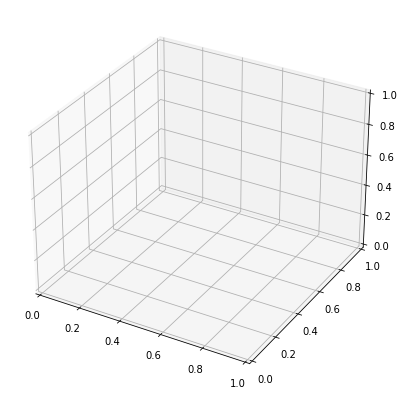

In [21]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pickle as pickle
import numpy as np


fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")



plt.title("Animation")

fileResultPickle = open("output3DPickle2", "rb")
outdata = pickle.load(fileResultPickle)
fileResultPickle.close()

connection = [['kuning kehijauan','hijau tua'],
              ['hijau tua','biru muda'],
              ['biru muda','oranye'],
              ['oranye','ungu'],
              ['ungu','biru telur unta']]

def init_func():
    ax.clear()

def updatefig(i):
    ax.clear()
    ax.set_xlim3d(-100, 100)
    ax.set_ylim3d(-50, 300)
    ax.set_zlim3d(100, 400)
    for c in connection:
        p3ds = outdata[i+1]
        xs = [p3ds[c[0]][0],p3ds[c[1]][0]]
        ys = [p3ds[c[0]][1],p3ds[c[1]][1]]
        zs = [p3ds[c[0]][2],p3ds[c[1]][2]]
        ax.scatter3D(xs, ys, zs, c = "darkred")
        ax.plot(xs, ys, zs, c = "red")

anim = animation.FuncAnimation(fig, updatefig, len(outdata),init_func=init_func)
anim.save("./output/output2.gif",fps = 30)

In [16]:
# # import packages
# import matplotlib.pyplot as plt
# from skimage import exposure
# from skimage.exposure import match_histograms
# import cv2
  
# # reading main image
# cap1 = cv2.VideoCapture("video/take2/kanan/VID_gerakan3.mp4")
# success, img1 = cap1.read()

# img = cv2.imread("video/foto_1.png")
# print(type(img1))
# print(type(img))


# # checking the number of channels
# # print('No of Channel is: ' + str(img1.ndim))
  
# # reading reference image
# cap2 = cv2.VideoCapture("video/take2/tengah/VID_gerakan3.mp4")
# success, img2 = cap2.read()
# # checking the number of channels
# # print('No of Channel is: ' + str(img2.ndim))
  
# image = img1
# reference = img2
  
# matched = match_histograms(image, reference ,
#                            channel_axis=-1)
  
  
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, 
#                                     figsize=(8, 3),
#                                     sharex=True, sharey=True)
  
# for aa in (ax1, ax2, ax3):
#     aa.set_axis_off()
  
# ax1.imshow(image)
# ax1.set_title('Source')
# ax2.imshow(reference)
# ax2.set_title('Reference')
# ax3.imshow(matched)
# ax3.set_title('Matched')
  
# plt.tight_layout()
# plt.show()
  
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
  
# for i, img in enumerate((image, reference, matched)):
#     for c, c_color in enumerate(('red', 'green', 'blue')):
#         img_hist, bins = exposure.histogram(img[..., c], 
#                                             source_range='dtype')
#         axes[c, i].plot(bins, img_hist / img_hist.max())
#         img_cdf, bins = exposure.cumulative_distribution(img[..., c])
#         axes[c, i].plot(bins, img_cdf)
#         axes[c, 0].set_ylabel(c_color)
  
# axes[0, 0].set_title('Source')
# axes[0, 1].set_title('Reference')
# axes[0, 2].set_title('Matched')
  
# plt.tight_layout()
# plt.show()

## bottom

In [13]:
# Convert a JSON File to a CSV File
import pandas as pd

df = pd.read_json(r'D:\Users\Asus\Documents\bitbucket\kerjaan.json')
dfProjectSubsId = df["projectSubId"]
dfAutoRenewal = pd.DataFrame({"projectSubId" : [],
                              "activity" : []
                              })
for index, row in df.iterrows():
    dicty = {
        "projectSubId" : ["VALIDATEMSIDSN", "SUBMITORDER", "CALLBACK", "CHECKSTATUS", "UPDATE"],
        "activity" : [row["projectSubId"], row["projectSubId"], row["projectSubId"], row["projectSubId"], row["projectSubId"]]
    }
    dfTemp = pd.DataFrame(dicty)
    # print(dicty)
    dfAutoRenewal = pd.concat([dfAutoRenewal, dfTemp], ignore_index = True)

# print(dfAutoRenewal)
dfAutoRenewal.to_csv(r'D:\Users\Asus\Documents\bitbucket\kerjaanAutoRenewal.csv', index=False)

In [ ]:
# def objectTrackingOpticalFlow(videoPath, isLive, isShow):
#     if(not(isLive)):
#         # Create opencv video capture object
#         # cap = cv2.VideoCapture('video/tes_jarak_bola.mp4')
#         cap = cv2.VideoCapture(videoPath)
#     else:
#         cap = cv2.VideoCapture(0)

#     cap.set(3, 1280)
#     cap.set(4, 720)
    
#     myColorFinder = ColorFinder(0)
    
#     # Parameters for lucas kanade optical flow
#     lk_params = dict( winSize  = (15, 15),
#                   maxLevel = 2,
#                   criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

#     kalmanFilterBola = {}
#     kalmanFilterSupportingAttributes = {}
#     kalmanFilterHasil = {}
#     for warnaBola in warnaBolaHsv:
#         kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
#         kalmanFilterSupportingAttributes[warnaBola] = {"is_active" : False, "is_new" : True, "frame_since_last_detected" : 0}
#         kalmanFilterHasil[warnaBola] = []
#     MAXFRAMESINCEDETECTED = 10

#     #define kernel size  
#     kernel = np.ones((7,7),np.uint8)

#     # init object
#     x, y, z = 0, 0, 0

#     try:
#         ret, oldFrame = cap.read()
#         oldFrameGray = cv2.cvtColor(oldFrame, cv2.COLOR_BGR2GRAY)
#         while(True):
#             success, img = cap.read()
#             imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             allMask = []
#             # h, w, _ = img.shape
#             for warnaBola in warnaBolaHsv:
#                 hsvVals = warnaBolaHsv[warnaBola]
#                 KF_1D = kalmanFilterBola[warnaBola]
#                 kalmanFilterSupportingAttributesLocal = kalmanFilterSupportingAttributes[warnaBola]
#                 kalmanFilterHasilLokal = kalmanFilterHasil[warnaBola]
#                 imageColor, mask = myColorFinder.update(img, hsvVals)
#                 # print("mask shape:", np.shape(mask), "value:", np.unique(mask))

#                 # Remove unnecessary noise from mask
#                 mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
#                 mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

#                 contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#                 if(len(contours) > 0):
#                     if(not(kalmanFilterSupportingAttributesLocal["is_active"])):
#                         kalmanFilterBola[warnaBola] = {"KF_X" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Y" : KalmanFilter1D(0.1, 1, 1, 0.1), "KF_Z" : KalmanFilter1D(0.1, 1, 1, 0.1)}
#                         KF_1D = kalmanFilterBola[warnaBola]
#                         kalmanFilterSupportingAttributesLocal["is_active"] = True

#                     kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] = 0

#                     biggestContour = max(contours, key = cv2.contourArea)
#                     cv2.drawContours(img, biggestContour, -1, (0,255,0), 3)

#                     # bisa dipake buat approximate lokasi di video depth
#                     # https://stackoverflow.com/questions/69637673/finding-points-within-a-contour-using-opencv
#                     # https://stackoverflow.com/questions/70438811/reading-frames-from-two-video-sources-is-not-in-sync-opencv
#                     x,y,w,h = cv2.boundingRect(biggestContour) 
#                     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

#                     # Predict
#                     # (x, y, z) = KF.predict()
#                     x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()
#                     # calculate optical flow
#                     p1, st, err = cv2.calcOpticalFlowPyrLK(oldFrameGray, imgGray, p0, None, **lk_params)

#                     # Select good points
#                     if p1 is not None:
#                         good_new = p1[st==1]
#                         good_old = p0[st==1]

#                     # Update
#                     M = cv2.moments(biggestContour)
#                     if(M['m00'] != 0):
#                         cx = int(M['m10']/M['m00'])
#                         cy = int(M['m01']/M['m00'])
#                     else:
#                         cx = x
#                         cy = y
#                     # (x1, y1, z1) = KF.update([cx, cy, 0])
#                     x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

#                     # Draw a rectangle as the predicted object position
#                     cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
#                     cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
#                 else:
#                     if(kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] > MAXFRAMESINCEDETECTED):
#                         kalmanFilterSupportingAttributesLocal["is_active"] = False
#                     else:
#                         kalmanFilterSupportingAttributesLocal["frame_since_last_detected"] += 1
#                         # Predict
#                         # (x, y, z) = KF.predict()
#                         x, y, z = KF_1D["KF_X"].predict(), KF_1D["KF_Y"].predict(), KF_1D["KF_Z"].predict()

#                         cx = x
#                         cy = y
#                         x1, y1, z1 = KF_1D["KF_X"].update(cx), KF_1D["KF_Y"].update(cy), KF_1D["KF_Z"].update(0)

#                         # Draw a rectangle as the predicted object position
#                         cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 0, 255), 2)
#                         cv2.rectangle(img, (int(x - 15), int(y - 15)), (int(x + 15), int(y + 15)), (0, 255, 255), 2)
#                 if(kalmanFilterSupportingAttributesLocal["is_active"]):
#                     cv2.putText(img, warnaBola, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
#                     cv2.putText(img, str(cv2.contourArea(biggestContour)), (int(x), int(y)-25), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
#                     kalmanFilterHasilLokal.append([x[0,0], y[0,0]])
#                     # fileResult1.write("{:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
#                     # print("nilai: {:.3f}, {:.3f}, ".format(x[0,0], y[0,0]))
#                     # print("shape: {}, {}, ".format(np.shape(x[0,0]), np.shape(y[0,0])))
#                 else:
#                     # fileResult1.write("-, -, ")
#                     kalmanFilterHasilLokal.append([-1, -1])
#                 allMask.append(mask)
#             # fileResult1.write("\n")

#             if(isShow):
#                 # imageStack = cvzone.stackImages([img, mask], 2, 0.5)
#                 cv2.imshow("imageOri", img)

#                 imageStack = cvzone.stackImages(allMask, 2, 0.5)
#                 cv2.imshow("imageStack", imageStack)


#             if cv2.waitKey(2) & 0xFF == ord('q'):
#                     cap.release()
#                     cv2.destroyAllWindows()
#                     break

#             cv2.waitKey(1)
#     except Exception as e:
#         print("error: ", e)
#         cap.release()
#         cv2.destroyAllWindows()
#     return kalmanFilterHasil
#     # fileResult1.close()